In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import LabelEncoder
from numpy import concatenate
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error


In [3]:
data_features_train = pd.read_csv("data/dengue_features_train.csv")
data_label_train = pd.read_csv("data/dengue_labels_train.csv")
data =  pd.merge(data_features_train, data_label_train, how='left', on=['city', 'year', 'weekofyear']).drop("week_start_date", axis=1)
#data['week_start_date']=data['week_start_date'].astype('datetime64[ns]')
#data.set_index("week_start_date")
list(data)

['city',
 'year',
 'weekofyear',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm',
 'total_cases']

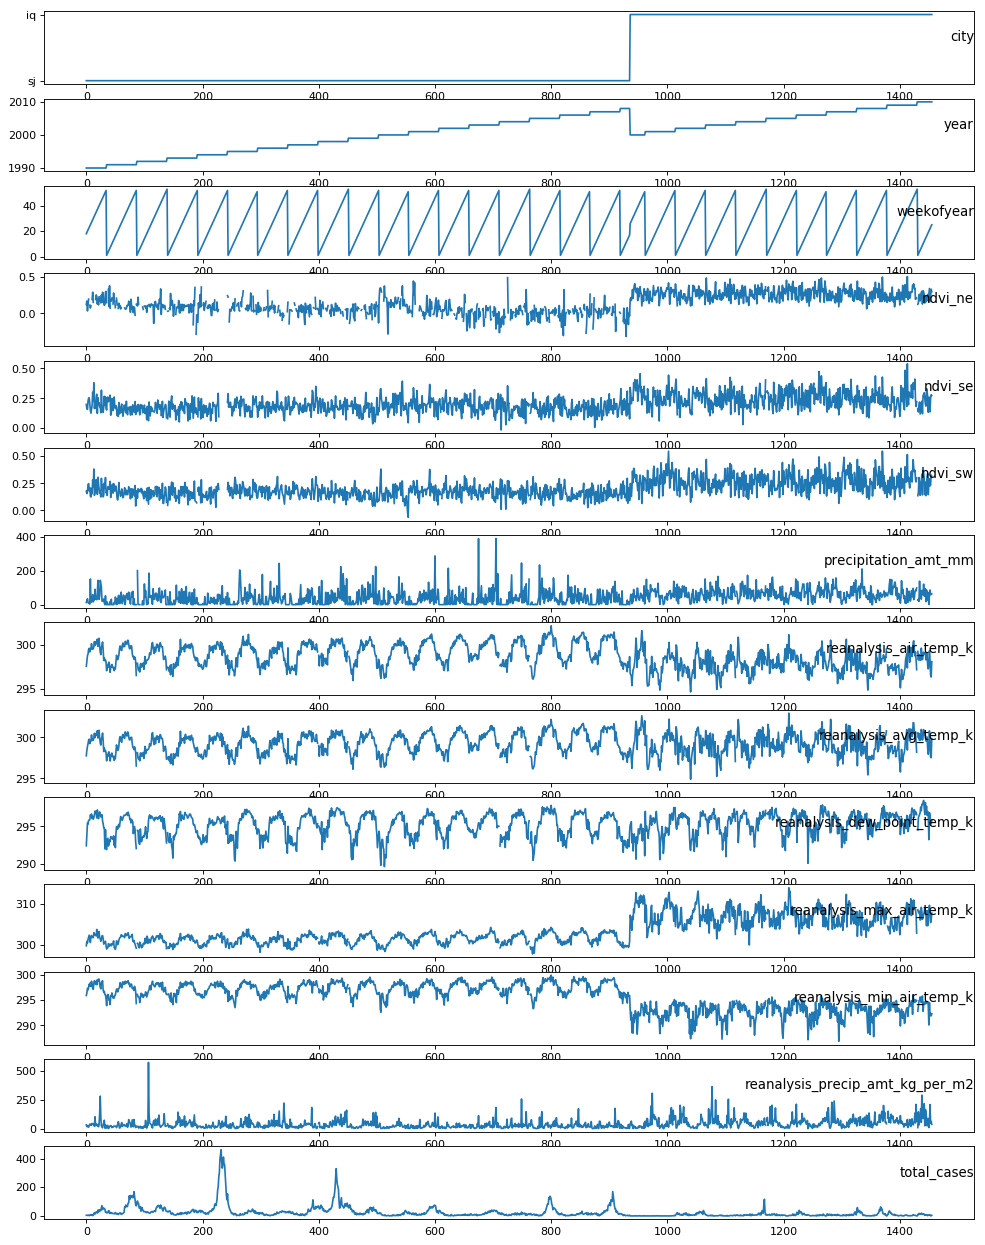

In [4]:
values = data.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7,8,9,10,11,12,13,23]
i = 1
# plot each column
plt.figure(num=None, figsize=(15, 20), dpi=80, facecolor='w', edgecolor='k')
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(data.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [10]:

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
# load dataset
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
class LabelBinarizerPipelineFriendly(LabelBinarizer):
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelBinarizerPipelineFriendly, self).fit(X)
    def transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).transform(X)
    def fit_transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).fit(X).transform(X)


In [24]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.impute import SimpleImputer
encoder = LabelBinarizerPipelineFriendly()
dataset = data
dataset["city"] = encoder.fit_transform(dataset["city"])
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
imputer.fit(dataset)
values=imputer.transform(dataset)
# integer encode direction


# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(["var{}(t)".format(i) for i in range(1,24)], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1        1.0        0.0   0.326923   0.578226   0.614835   0.386418   
2        1.0        0.0   0.346154   0.629943   0.657063   0.321190   
3        1.0        0.0   0.365385   0.479441   0.690881   0.311879   
4        1.0        0.0   0.384615   0.584823   0.770066   0.438912   
5        1.0        0.0   0.403846   0.658698   0.788882   0.481601   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)    ...     var16(t-1)  \
1   0.395544   0.031797   0.388287    0.354668    ...       0.031797   
2   0.359233   0.058423   0.472710    0.441780    ...       0.058423   
3   0.384430   0.088428   0.548061    0.495998    ...       0.088428   
4   0.491150   0.039324   0.575260    0.539555    ...       0.039324   
5   0.509943   0.019252   0.645515    0.593777    ...       0.019252   

   var17(t-1)  var18(t-1)  var19(t-1)  var20(t-1)  var21(t-1)  var22(t-1)  \
1    0.262659    0.086660    0.430091    0.210393    0.174193  

In [43]:
# split into train and test sets
values = reframed.values
n_train_week = 52*15
train = values[:n_train_week, :]
test = values[n_train_week:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(780, 1, 24) (780,) (675, 1, 24) (675,)


In [44]:
import tensorflow as tf
from tensorflow.keras import layers

print(tf.VERSION)
print(tf.keras.__version__)

1.13.1
2.2.4-tf


In [45]:
# design network

model = tf.keras.Sequential()
model.add(layers.LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=52, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history


Train on 780 samples, validate on 675 samples
Epoch 1/50
 - 3s - loss: 0.0552 - val_loss: 0.0286
Epoch 2/50
 - 0s - loss: 0.0527 - val_loss: 0.0265
Epoch 3/50
 - 0s - loss: 0.0532 - val_loss: 0.0274
Epoch 4/50
 - 0s - loss: 0.0545 - val_loss: 0.0287
Epoch 5/50
 - 0s - loss: 0.0511 - val_loss: 0.0299
Epoch 6/50
 - 0s - loss: 0.0504 - val_loss: 0.0315
Epoch 7/50
 - 0s - loss: 0.0502 - val_loss: 0.0310
Epoch 8/50
 - 0s - loss: 0.0520 - val_loss: 0.0291
Epoch 9/50
 - 0s - loss: 0.0484 - val_loss: 0.0232
Epoch 10/50
 - 0s - loss: 0.0424 - val_loss: 0.0213
Epoch 11/50
 - 0s - loss: 0.0389 - val_loss: 0.0227
Epoch 12/50
 - 0s - loss: 0.0379 - val_loss: 0.0256
Epoch 13/50
 - 0s - loss: 0.0378 - val_loss: 0.0293
Epoch 14/50
 - 0s - loss: 0.0360 - val_loss: 0.0293
Epoch 15/50
 - 0s - loss: 0.0336 - val_loss: 0.0278
Epoch 16/50
 - 0s - loss: 0.0312 - val_loss: 0.0260
Epoch 17/50
 - 0s - loss: 0.0298 - val_loss: 0.0269
Epoch 18/50
 - 0s - loss: 0.0288 - val_loss: 0.0305
Epoch 19/50
 - 0s - loss: 0

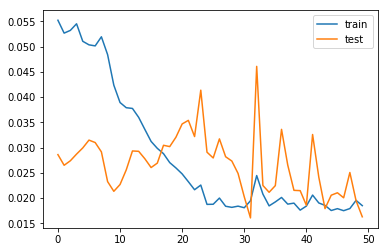

In [46]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [47]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE


In [48]:
from sklearn.metrics import mean_absolute_error
rmse = mean_absolute_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.016


In [49]:
test_ = pd.read_csv("data/dengue_features_test.csv")
pd.merge(test_,data_label_train,  how='left', on=['city', 'year','city', 'weekofyear']).drop("week_start_date", axis=1)

city  year  weekofyear   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
0     sj  2008          18 -0.018900 -0.018900  0.102729  0.091200   
1     sj  2008          19 -0.018000 -0.012400  0.082043  0.072314   
2     sj  2008          20 -0.001500       NaN  0.151083  0.091529   
3     sj  2008          21       NaN -0.019867  0.124329  0.125686   
4     sj  2008          22  0.056800  0.039833  0.062267  0.075914   
5     sj  2008          23 -0.044000 -0.030467  0.132000  0.083529   
6     sj  2008          24 -0.044300 -0.024925  0.132271  0.159157   
7     sj  2008          25       NaN  0.082150  0.144371  0.116729   
8     sj  2008          26  0.010800  0.049900  0.100571  0.117329   
9     sj  2008          27  0.072667  0.106660  0.155429  0.164900   
10    sj  2008          28 -0.046450  0.006825  0.260286  0.214729   
11    sj  2008          29       NaN       NaN  0.195843  0.176157   
12    sj  2008          30  0.208300  0.429500  0.277683  0.245650   
13    sj  2008          31  0.000200  0.003900  0.109067  0.086483   
14    sj  2008          32  0.112200  0.032200  0.194186  0.205771   
15    sj  2008          33       NaN       NaN  0.058900  0.065643   
16    sj  2008          34  0.289150  0.241033  0.240600  0.208557   
17    sj  2008          35  0.113200       NaN  0.226083  0.198243   
18    sj  2008          36       NaN  0.017300  0.190417  0.119983   
19    sj  2008          37  0.361900  0.649000  0.146400  0.131386   
20    sj  2008          38  0.091375  0.164050  0.251667  0.196450   
21    sj  2008          39  0.079500  0.103675  0.282686  0.261300   
22    sj  2008          40 -0.137350  0.130950  0.271886  0.270029   
23    sj  2008          41  0.130600  0.089700  0.186086  0.196443   
24    sj  2008          42  0.183400  0.117550  0.152457  0.142500   
25    sj  2008          43  0.033250  0.074867  0.336314  0.252657   
26    sj  2008          44  0.083400  0.075700  0.073629  0.123729   
27    sj  2008          45 -0.094400 -0.004950  0.143800  0.130314   
28    sj  2008          46  0.101100  0.074000  0.237600  0.175529   
29    sj  2008          47       NaN  0.044000  0.221043  0.183529   
..   ...   ...         ...       ...       ...       ...       ...   
386   iq  2012          48  0.376286  0.388143  0.433229  0.362914   
387   iq  2012          49  0.367617  0.354980  0.325817  0.281133   
388   iq  2012          50  0.130650  0.265457  0.223043  0.136517   
389   iq  2012          51  0.256983  0.223471  0.233883  0.253100   
390   iq  2013           1  0.255829  0.268657  0.268414  0.244471   
391   iq  2013           2  0.188229  0.139143  0.252729  0.170586   
392   iq  2013           3  0.252200  0.184743  0.241700  0.233014   
393   iq  2013           4  0.183729  0.127057  0.165986  0.163729   
394   iq  2013           5  0.368857  0.375329  0.336871  0.418014   
395   iq  2013           6  0.274957  0.270914  0.293043  0.294400   
396   iq  2013           7  0.267029  0.190729  0.279186  0.282186   
397   iq  2013           8  0.297967  0.327750  0.244357  0.308671   
398   iq  2013           9  0.345517  0.346867  0.337117  0.382550   
399   iq  2013          10  0.295343  0.309857  0.254686  0.263729   
400   iq  2013          11  0.223671  0.119450  0.224800  0.228371   
401   iq  2013          12  0.231800  0.195583  0.204786  0.250186   
402   iq  2013          13  0.263429  0.210614  0.269414  0.245871   
403   iq  2013          14  0.223543  0.208543  0.239971  0.218557   
404   iq  2013          15  0.263200  0.237400  0.250143  0.199114   
405   iq  2013          16  0.309029  0.270267  0.235500  0.259686   
406   iq  2013          17  0.193314  0.247057  0.275643  0.372729   
407   iq  2013          18  0.385143  0.369700  0.375933  0.354214   
408   iq  2013          19  0.396343  0.292471  0.333400  0.352271   
409   iq  2013          20  0.352557  0.281050  0.307071  0.277400   
410   iq  2013          21  0.236829  0.293857  0.223443  0.299429   
411   iq  2013

In [56]:
test_ = pd.read_csv("data/dengue_features_test.csv").drop("week_start_date", axis=1)
test_["total_cases"]=0
test_["city"] = encoder.fit_transform(test_["city"])

test_values = imputer.transform(test_)
# integer encode direction
# ensure all data is float
test_values = test_values.astype('float32')
# normalize features
test_scaled = scaler.fit_transform(test_values)
test_X = test_scaled.reshape((test_scaled.shape[0], 1, test_scaled.shape[1]))

print(test_X.shape)


(416, 1, 24)


In [57]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
inv_yhat
inv_yhat
# calculate RMSE

array([ 2.00217925e-02,  1.87015049e-02,  8.16992205e-03,  1.53076621e-02,
        1.76631995e-02,  2.02098805e-02,  2.22895481e-02,  1.52810020e-02,
        1.66717712e-02,  1.91533100e-02,  1.64139345e-02,  1.61984861e-02,
        1.32425642e-02,  1.73033848e-02,  1.99007690e-02,  1.87878385e-02,
        1.51859513e-02,  1.66435689e-02,  1.62342433e-02,  2.34534908e-02,
        1.94667876e-02,  2.31642593e-02,  1.68492142e-02,  1.99310873e-02,
        2.60309707e-02,  2.23861150e-02,  2.29660161e-02,  1.95772778e-02,
        1.86850950e-02,  1.98755767e-02,  2.17812136e-02,  2.14175228e-02,
        1.55403065e-02,  1.30195925e-02,  1.27869816e-02,  9.20012221e-03,
        9.39293858e-03,  1.18419053e-02,  1.45008760e-02,  6.08495809e-03,
        1.35071157e-02,  1.13501707e-02,  1.74564589e-02,  9.86723788e-03,
        1.40184313e-02,  1.67037975e-02,  1.10894656e-02,  1.05357300e-02,
        1.37810409e-02,  1.06742634e-02,  9.08715650e-03,  1.02601070e-02,
        1.06838895e-02,  

In [38]:
final_predictions = final_model.predict(X_test_prepared).round().astype('int64')
test_['total_cases'] = pd.Series(final_predictions, index=test_.index)

out = test_[['city','year','weekofyear','total_cases']]
out.to_csv("results/result4_svc",index=False)

NameError: name 'final_model' is not defined

In [167]:
inv_y

array([0.01518438, 0.01952278, 0.02819957, 0.03470716, 0.01518438,
       0.01952278, 0.00433839, 0.02819957, 0.01735358, 0.00433839,
       0.00650759, 0.01084599, 0.01518438, 0.00650759, 0.01084599,
       0.01301518, 0.01084599, 0.01084599, 0.        , 0.00867679,
       0.00650759, 0.00650759, 0.01084599, 0.00650759, 0.01518438,
       0.02386117, 0.00433839, 0.01301518, 0.01735358, 0.05206074,
       0.06073753, 0.05639913, 0.01735358, 0.01952278, 0.02603037,
       0.03904555, 0.01952278, 0.01952278, 0.01301518, 0.01301518,
       0.01735358, 0.01084599, 0.01518438, 0.01301518, 0.01084599,
       0.00650759, 0.0021692 , 0.        , 0.0021692 , 0.00433839,
       0.00650759, 0.00433839, 0.00433839, 0.00433839, 0.00433839,
       0.00433839, 0.00867679, 0.        , 0.01301518, 0.00650759,
       0.00433839, 0.01301518, 0.00433839, 0.01518438, 0.00867679,
       0.01301518, 0.01301518, 0.00433839, 0.02819957, 0.02169197,
       0.01084599, 0.00433839, 0.03036876, 0.01301518, 0.02169

In [95]:
test_X

array([[ 0.17912039,  0.03307291, -0.29767823, ..., -0.8959904 ,
        -0.7214514 ,  0.        ],
       [ 0.17912039,  0.09967618,  0.5771102 , ..., -1.1514238 ,
        -0.27150616,  0.        ],
       [ 0.17912039,  0.16627945, -0.24800782, ..., -1.2791405 ,
        -0.82969296,  0.        ],
       ...,
       [ 1.6588327 , -0.29994342,  0.15022813, ..., -0.257407  ,
        -0.05290069,  0.        ],
       [ 1.6588327 , -0.23334016,  0.8142833 , ..., -1.8538655 ,
        -0.6726366 ,  0.        ],
       [ 1.6588327 , -0.16673689,  1.4780115 , ..., -0.7044154 ,
        -0.49011165,  0.        ]], dtype=float32)

In [168]:
inv_yhat

array([ 3.99221443e-02,  1.48889925e-02,  2.86623854e-02,  1.65858548e-02,
        2.44577080e-02,  3.05282827e-02,  2.10610386e-02,  2.27036569e-02,
        3.70112658e-02,  3.04259751e-02,  1.33896153e-02,  5.72475325e-03,
        1.19385393e-02,  8.45230557e-03, -7.07346108e-03, -6.67863898e-03,
        1.48883406e-02,  1.54017955e-02,  7.84191070e-04, -1.57294632e-03,
        4.72208019e-03,  4.86942194e-03,  1.43828951e-02,  3.87619287e-02,
        2.11683568e-02,  2.49503069e-02,  3.20038311e-02,  2.71613915e-02,
        3.66455652e-02,  4.08599973e-02,  3.73086631e-02,  4.32293564e-02,
        5.20939343e-02,  2.21309252e-02,  2.57108007e-02,  2.22707335e-02,
        3.91207077e-02,  1.84421800e-02,  1.95670072e-02,  1.84756145e-02,
        1.17204729e-02,  2.35496387e-02,  1.40449759e-02, -2.94587761e-03,
       -1.53175625e-03,  9.76454467e-03,  5.01636509e-03, -8.64477642e-03,
       -7.05206115e-03, -7.61392526e-03,  9.83006880e-03,  7.57858157e-03,
        1.66778849e-03, -

In [98]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = inv_y[:,0]
# calculate RMSE
